#### Author: Vaishnavi Adhav

##### Description

1. Create a pipeline to calculate NDMI Indice from Sentinel 2 imageries. Imageries are available on the public AWS s3 bucket here https://registry.opendata.aws/sentinel-2-l2a-cogs/

2. Inputs are date and a farm polygon (choose your favourite farm).

3. Output as an image in .png format (colored red-yellow-green) and mean NDMI value.

4. Brownie points for  solving the below edge case: Incase that particular date does not have sentinel 2 data; the pipeline should pull the latest available sentinel 2 imagery to calculate NDMI.

### 1. Import Libraries

In [1]:
from pystac_client import Client
import geopandas as gpd
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

### 2. Data Collection

In [2]:
# Define STAC API URL and the collection to access
api_url = "https://earth-search.aws.element84.com/v1"

In [3]:
# Connect to the STAC API
client = Client.open(api_url)

In [4]:
# Load shapefile
shapefile_path = r'C:\Users\vaish\Downloads\Boomitra\aoi.shp'
gdf = gpd.read_file(shapefile_path)

In [5]:
# Ensure CRS is WGS84
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

In [6]:
# Use the first geometry in the shapefile for clipping
geometry = gdf.geometry.iloc[0]

In [7]:
# Describe image collection to be used
collection = "sentinel-2-l2a"

In [8]:
def search_stac_items(client, collection, geometry, primary_start_date, primary_end_date, fallback_start_date, fallback_end_date, max_items=10):
    """
    Searches for items in a STAC collection using the provided geometry and date range.
    If no items are found in the primary date range, a fallback date range is used.

    Parameters:
    - client: The STAC API client.
    - collection: The STAC collection to search in.
    - geometry: The geometry for spatial filtering.
    - primary_start_date: The start date for the primary search.
    - primary_end_date: The end date for the primary search.
    - fallback_start_date: The start date for the fallback search.
    - fallback_end_date: The end date for the fallback search.
    - max_items: The maximum number of items to return.

    Returns:
    - items: A list of found items or raises an error if none are found.
    """
    # Perform the initial search using the primary date range
    search = client.search(
        collections=[collection],
        intersects=geometry,
        datetime=f"{primary_start_date}/{primary_end_date}",
        sortby=[{"field": "properties.datetime", "direction": "desc"}],
        max_items=max_items,
    )

    items = list(search.get_items())

    # Check if any items were found; if not, use fallback date range
    if not items:
        print("No items found for the specified date range. Using fallback date range.")
        search = client.search(
            collections=[collection],
            intersects=geometry,
            datetime=f"{fallback_start_date}/{fallback_end_date}",
            sortby=[{"field": "properties.datetime", "direction": "desc"}],
            max_items=max_items,
        )
        items = list(search.get_items())

        if not items:
            raise ValueError("No items found even with the fallback date range.")

    return items

In [9]:
# Define the preferred and fallback date ranges
primary_start_date = "2024-06-01T00:00:00Z"
primary_end_date = "2024-06-30T23:59:59Z"
fallback_start_date = "2024-01-01T00:00:00Z"
fallback_end_date = "2024-06-30T23:59:59Z"

In [10]:
# Perform the search using the defined function
items = search_stac_items(
    client,
    collection,
    geometry,
    primary_start_date,
    primary_end_date,
    fallback_start_date,
    fallback_end_date
)

C:\Users\vaish\anaconda3\envs\gisenv\Lib\site-packages\pystac_client\item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [11]:
# Use the first item and check the asset keys for "swir16" and "nir" bands
item = items[0]
assets = item.assets

In [12]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

In [13]:
# "swir16" is swir and "nir08" is NIR
swir16_uri = item.assets["swir16"].href
nir_uri = item.assets["nir08"].href

In [14]:
# Load the bands using rioxarray
swir16 = rioxarray.open_rasterio(swir16_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

In [15]:
# Clip the bands using the shapefile geometry
swir16_clip = swir16.rio.clip([geometry], gdf.crs, drop=True)
nir_clip = nir.rio.clip([geometry], gdf.crs, drop=True)

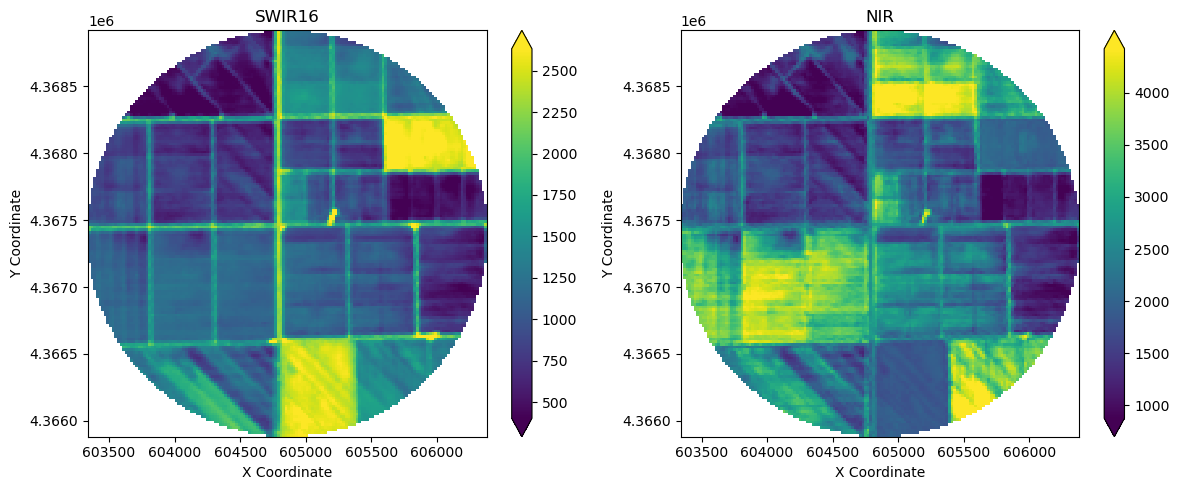

In [16]:
# Set up the figure and axes
# Create 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot SWIR16
swir16_clip.plot(ax=axes[0], robust=True, cmap='viridis')
axes[0].set_title("SWIR16")
axes[0].set_xlabel("X Coordinate")
axes[0].set_ylabel("Y Coordinate")

# Plot NIR
nir_clip.plot(ax=axes[1], robust=True, cmap='viridis')
axes[1].set_title("NIR")
axes[1].set_xlabel("X Coordinate")
axes[1].set_ylabel("Y Coordinate")

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [17]:
print(swir16_clip.shape, nir_clip.shape)

(1, 152, 152) (1, 152, 152)


In [18]:
swir16_clip_matched = swir16_clip.rio.reproject_match(nir_clip)
print(swir16_clip_matched.shape)

(1, 152, 152)


### 3. Calculate NDMI Index

In [19]:
# Calculate NDMI
ndmi = (nir_clip - swir16_clip) / (nir_clip + swir16_clip)

In [20]:
# Remove the extra dimension if present
# Remove any single-dimensional entries from the shape
ndmi_2d = ndmi.squeeze()

### 4. Plot and Save NDMI Index in .png format

NDMI image saved to C:\Users\vaish\Downloads\Boomitra\ndmi.png


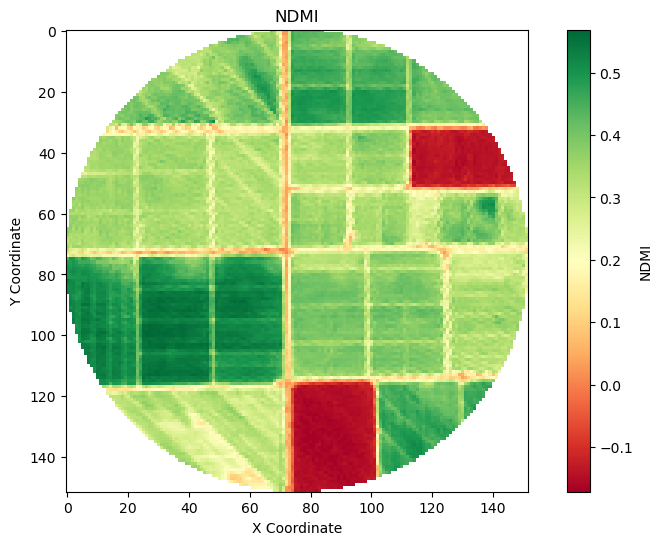

In [27]:
# Plot NDMI
plt.figure(figsize=(10, 6))
plt.imshow(ndmi_2d, cmap='RdYlGn')
plt.colorbar(label="NDMI")

# Set plot titles and labels
plt.title("NDMI")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Save the plot as a PNG file
output_path = r"C:\Users\vaish\Downloads\Boomitra\ndmi.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"NDMI image saved to {output_path}")

# Display the plot
plt.show()

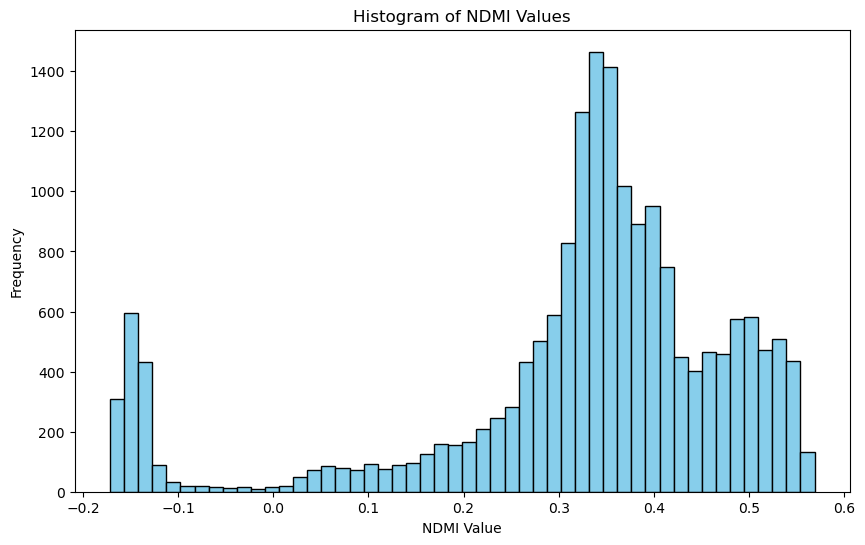

In [22]:
# Flatten the NDMI data to a 1D array for histogram
# Convert to numpy array and flatten
ndmi_values = ndmi_2d.values.flatten()

# Plot histogram of NDMI values
plt.figure(figsize=(10, 6))
plt.hist(ndmi_values, bins=50, edgecolor='k', color='skyblue')
plt.title("Histogram of NDMI Values")
plt.xlabel("NDMI Value")
plt.ylabel("Frequency")

# Show the plot
plt.show()

### 5. Calculate Mean of NDMI Index

In [25]:
# Calculate the mean NDMI value
mean_ndmi = ndmi_2d.mean().item()
print('Mean NDMI Value:', mean_ndmi)

Mean NDMI Value: 0.3203018605709076


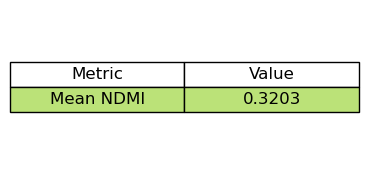

In [23]:
# Calculate the mean NDMI value
# Extract the scalar value
mean_ndmi = ndmi_2d.mean().item()

# Create a color based on the mean NDMI value
# Here I use a simple approach: scale from red (low) to green (high)
# Adjust the color scaling according to NDMI range and preferences
# Normalize NDMI value between -1 and 1
color = plt.cm.RdYlGn((mean_ndmi + 1) / 2)

# Plot the table
# Create a figure for the table
fig, ax = plt.subplots(figsize=(3, 2))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table
table_data = [["Mean NDMI", f"{mean_ndmi:.4f}"]]
table = ax.table(cellText=table_data, colLabels=["Metric", "Value"], cellColours=[[color, color]], loc='center', cellLoc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)

# Scale the table for better visibility
table.scale(1.5, 1.5)

# Show the plot with the table
plt.show()

In [24]:
# Save NDMI as a TIFF file
output_tif_path = r"C:\Users\vaish\Downloads\Boomitra\ndmi.tif"
ndmi_2d.rio.to_raster(output_tif_path)